In [1]:
## Import things

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import networkX
import networkx as nx

# Import multiNetX
import multinetx as mx

# Need to save as json
import scipy.io as sio
from networkx.readwrite import json_graph
import json
import pandas as pd

print("Done importing packages :)")

Done importing packages :)


## Multilayer network ex 1: Two aspects, two layers

Aspect L1: nodes as usual
Aspect L2: "A" or "B"

In [13]:
nNodes = 10

g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)

# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*3,nNodes*3)))
adj_block[0:  nNodes,  nNodes:2*nNodes] = np.identity(nNodes)    # L_12
adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2],
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




done writing file


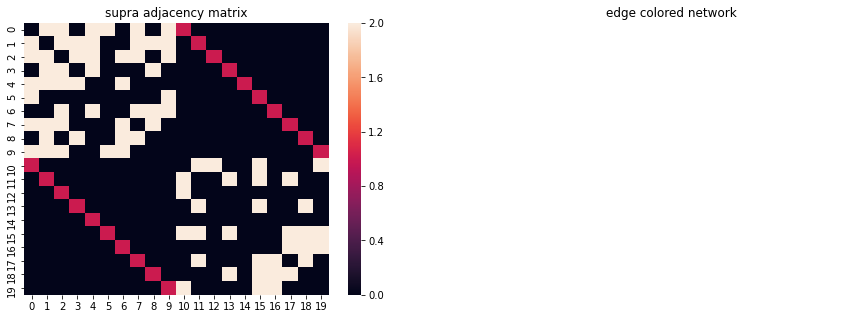

In [15]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
# pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
#                       layer_vertical_shift=0.3,
#                       layer_horizontal_shift=0.0,
#                       proj_angle=47)

# pos = [nx.layout.fruchterman_reingold_layout(g1, dim=3)
#             for i in range(mg.get_number_of_layers())
#         ]
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)
# pos = nx.circular_layout(g1)

# pos = mx.get_position3D(mg)
# mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
#                  edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
#                  edge_cmap=plt.cm.jet_r)
# plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

nLevels = 2
L2_classes = np.arange(nLevels)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

scalefact = 20
scalefact = 20
id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLevels)}
x_dict = {}
y_dict = {}
L2_dict = {}
z_dict = {}
z_shift = 2
L1_dict = {}
for level in L2_classes:
    pos_dict = pos
    x_dict.update({(key+(level*nNodes)):float(pos_dict[key][0]+scalefact) for key in pos_dict})
    y_dict.update({(key+(level*nNodes)):float(pos_dict[key][1]+scalefact) for key in pos_dict})
    L2_dict.update({i:float(level) for i in (np.arange(nNodes)+ (level*nNodes))})
    z_dict.update({i:float(level*z_shift) for i in (np.arange(nNodes) + (level*nNodes))})
    L1_dict.update({(i+level*nNodes):int(i) for i in np.arange(nNodes)})


# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, z_dict, name = "z")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

# ## Set edge attributes
# edge_dict = {}
# for edge in G.edges():
    
#     edge_dict[edge] = birth_times[max(edge[0],edge[1])]

# edge_dict
# nx.set_edge_attributes(G,edge_dict, name = "birth_time")

## Write to json file

G_json = json_graph.node_link_data(G)
with open('data/mx_slide9.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")

## Ex 2: 2 aspects, 5 layers


In [51]:
nNodes = 10
nLayers = 5

g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=192)
g4 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=19)
g5 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)

# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3,g4,g5],
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




done writing file


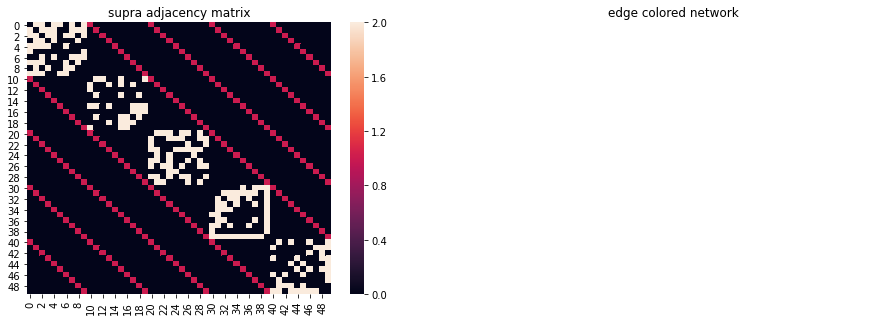

In [53]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
# pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
#                       layer_vertical_shift=0.3,
#                       layer_horizontal_shift=0.0,
#                       proj_angle=47)

# pos = [nx.layout.fruchterman_reingold_layout(g1, dim=3)
#             for i in range(mg.get_number_of_layers())
#         ]
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# pos = mx.get_position3D(mg)
# mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
#                  edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
#                  edge_cmap=plt.cm.jet_r)
# plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

nLevels = 5
L2_classes = np.arange(nLevels)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

scalefact = 20
id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLevels)}
x_dict = {}
y_dict = {}
L2_dict = {}
z_dict = {}
z_shift = 2
L1_dict = {}
for level in L2_classes:
    pos_dict = pos
    x_dict.update({(key+(level*nNodes)):float(pos_dict[key][0]+scalefact) for key in pos_dict})
    y_dict.update({(key+(level*nNodes)):float(pos_dict[key][1]+scalefact) for key in pos_dict})
    L2_dict.update({i:float(level) for i in (np.arange(nNodes)+ (level*nNodes))})
    z_dict.update({i:float(level*z_shift) for i in (np.arange(nNodes) + (level*nNodes))})
    L1_dict.update({(i+level*nNodes):int(i) for i in np.arange(nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, z_dict, name = "z")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

G_json = json_graph.node_link_data(G)
with open('data/mx_slide10_test2.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")

In [50]:
L1_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '0',
 11: '1',
 12: '2',
 13: '3',
 14: '4',
 15: '5',
 16: '6',
 17: '7',
 18: '8',
 19: '9',
 20: '0',
 21: '1',
 22: '2',
 23: '3',
 24: '4',
 25: '5',
 26: '6',
 27: '7',
 28: '8',
 29: '9',
 30: '0',
 31: '1',
 32: '2',
 33: '3',
 34: '4',
 35: '5',
 36: '6',
 37: '7',
 38: '8',
 39: '9',
 40: '0',
 41: '1',
 42: '2',
 43: '3',
 44: '4',
 45: '5',
 46: '6',
 47: '7',
 48: '8',
 49: '9'}

## Time series example

In [55]:
nNodes = 10
nLayers = 14

graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




done writing file


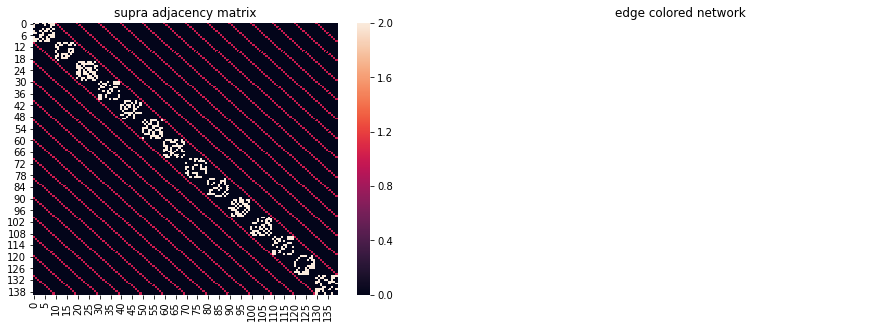

In [60]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
# pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
#                       layer_vertical_shift=0.3,
#                       layer_horizontal_shift=0.0,
#                       proj_angle=47)

# pos = [nx.layout.fruchterman_reingold_layout(g1, dim=3)
#             for i in range(mg.get_number_of_layers())
#         ]
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# pos = mx.get_position3D(mg)
# mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
#                  edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
#                  edge_cmap=plt.cm.jet_r)
# plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())


L2_classes = np.arange(nLayers)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

scalefact = 20
id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLevels)}
x_dict = {}
y_dict = {}
L2_dict = {}
z_dict = {}
z_shift = 2
L1_dict = {}
for level in L2_classes:
    pos_dict = pos
    x_dict.update({(key+(level*nNodes)):float(pos_dict[key][0]+scalefact) for key in pos_dict})
    y_dict.update({(key+(level*nNodes)):float(pos_dict[key][1]+scalefact) for key in pos_dict})
    L2_dict.update({i:float(level) for i in (np.arange(nNodes)+ (level*nNodes))})
    z_dict.update({i:float(level*z_shift) for i in (np.arange(nNodes) + (level*nNodes))})
    L1_dict.update({(i+level*nNodes):str(i) for i in np.arange(nNodes)})

# L1_dict = {i:str(i) for i in np.arange(nNodes*nLevels)}
# L2_dict = {i:0 for i in np.arange(nNodes)}
# L2_dict.update({i:1 for i in (np.arange(nNodes)+ nNodes)})
# L2_dict.update({i:2 for i in (np.arange(nNodes)+ 2*nNodes)})
# L2_dict.update({i:3 for i in (np.arange(nNodes)+ 3*nNodes)})
# L2_dict.update({i:4 for i in (np.arange(nNodes)+ 4*nNodes)})

# z_dict = {i:1*z_shift for i in np.arange(nNodes)}
# z_dict.update({i:(2)*z_shift for i in (np.arange(nNodes)+ nNodes)})
# z_dict.update({i:(3)*z_shift for i in (np.arange(nNodes)+ 2*nNodes)})
# z_dict.update({i:(4)*z_shift for i in (np.arange(nNodes)+ 3*nNodes)})
# z_dict.update({i:(5)*z_shift for i in (np.arange(nNodes)+ 4*nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, z_dict, name = "z")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

G_json = json_graph.node_link_data(G)
with open('data/mx_slide11.json', 'w') as fp:
    json.dump(G_json, fp)

# Also need to save sadj matrix
# np.savetxt('data/sadj_slide11.csv', mx.adjacency_matrix(mg,weight='weight').todense(), delimiter =', ') 

print("done writing file")

## Non-identity inter-layer connections

In [19]:
nNodes = 10
nLayers = 4

graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.random.choice([0,1],size=(nNodes,nNodes),replace=True,p=[0.9,0.1])   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




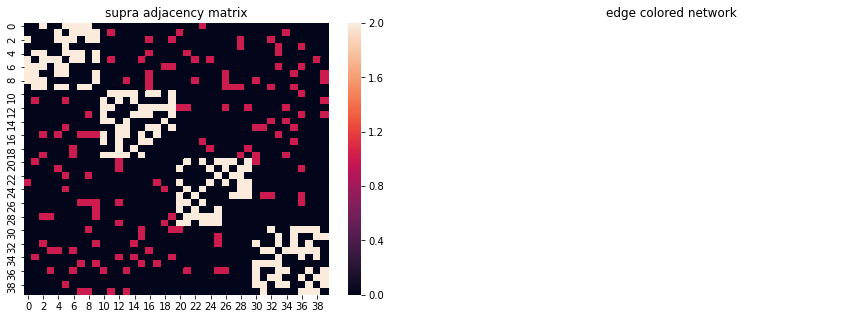

done writing file


In [21]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
# pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
#                       layer_vertical_shift=2.5,
#                       layer_horizontal_shift=0.0,
#                       proj_angle=30)
# mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
#                  edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
#                  edge_cmap=plt.cm.jet_r)

pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)
plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

L2_classes = np.arange(nLayers)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

scalefact = 20
id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLevels)}
x_dict = {}
y_dict = {}
L2_dict = {}
z_dict = {}
z_shift = 2
L1_dict = {}
for level in L2_classes:
    pos_dict = pos
    x_dict.update({(key+(level*nNodes)):float(pos_dict[key][0]+scalefact) for key in pos_dict})
    y_dict.update({(key+(level*nNodes)):float(pos_dict[key][1]+scalefact) for key in pos_dict})
    L2_dict.update({i:float(level) for i in (np.arange(nNodes)+ (level*nNodes))})
    z_dict.update({i:float(level*z_shift) for i in (np.arange(nNodes) + (level*nNodes))})
    L1_dict.update({(i+level*nNodes):int(i) for i in np.arange(nNodes)})


# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, z_dict, name = "z")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

# ## Set edge attributes
# edge_dict = {}
# for edge in G.edges():
    
#     edge_dict[edge] = birth_times[max(edge[0],edge[1])]

# edge_dict
# nx.set_edge_attributes(G,edge_dict, name = "birth_time")

## Write to json file

G_json = json_graph.node_link_data(G)
with open('data/mx_slide12.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")

## Case where nodes are not in every layer

In [50]:
nNodes = 10
nLayers = 3

g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=192)
# g4 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=19)
# g5 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)

# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2.
 2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4.
 4.]
done writing file


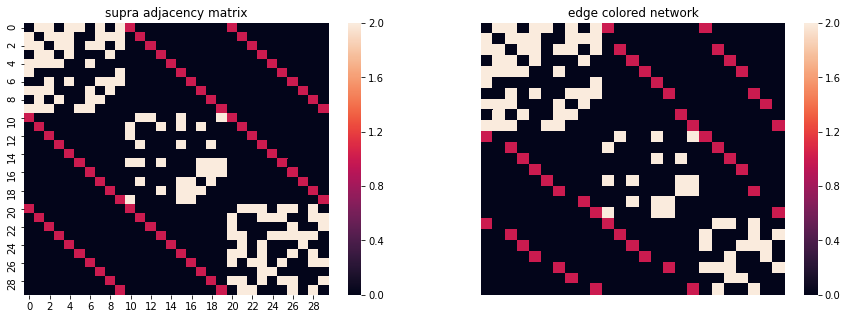

In [54]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
# pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
#                       layer_vertical_shift=0.3,
#                       layer_horizontal_shift=0.0,
#                       proj_angle=47)

# pos = [nx.layout.fruchterman_reingold_layout(g1, dim=3)
#             for i in range(mg.get_number_of_layers())
#         ]

## Need to assign positions under the assumption that all nodes exist in each layer, that way the nodes
# that show up in multiple layers will be on top of each other.
pos = nx.circular_layout(g1)

# pos = mx.get_position3D(mg)
# mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
#                  edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
#                  edge_cmap=plt.cm.jet_r)
# plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G1 = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

####### If I remove nodes from G, then all should be peachy.

nodes_to_remove = [11, 17, 21, 25, 28]
G1.remove_nodes_from(nodes_to_remove)

# Recreate the graph G to make the rest work nicely.
G = nx.from_numpy_array(nx.adjacency_matrix(G1).todense())



scalefact = 20
L2_classes = np.arange(nLayers)
L2_array_original = np.array([])
z_shift = 2
z_array_original = np.array([])
x_orig = np.array([])
y_orig = np.array([])
for level in L2_classes:
    L2_array_original = np.concatenate((L2_array_original, np.array([float(level) for i in np.arange(nNodes)])))
    z_array_original = np.concatenate((z_array_original, np.array([float(level*z_shift) for i in np.arange(nNodes)])))
    x_orig = np.concatenate((x_orig, [pos[key][0]+scalefact for key in pos]))
    y_orig = np.concatenate((y_orig, [pos[key][1]+scalefact for key in pos]))
    
print(L2_array_original)
L2_array = np.delete(L2_array_original, nodes_to_remove, 0)
print(L2_array)
print(z_array_original)
z_array = np.delete(z_array_original, nodes_to_remove, 0)
print(z_array)
x_array = np.delete(x_orig, nodes_to_remove, 0)
y_array = np.delete(y_orig, nodes_to_remove, 0)

## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
x_dict = {}
y_dict = {}
L2_dict = {i:l2 for i,l2 in enumerate(L2_array)}
z_dict = {i:z_val for i,z_val in enumerate(z_array)}
x_dict = {i:x_val for i,x_val in enumerate(x_array)}
y_dict = {i:y_val for i,y_val in enumerate(y_array)}
L1_dict = {}
for level in L2_classes:
    pos_dict = pos
#     x_dict.update({(key+(level*nNodes)):float(pos_dict[key][0]+scalefact) for key in pos_dict})
#     y_dict.update({(key+(level*nNodes)):float(pos_dict[key][1]+scalefact) for key in pos_dict})
#     L2_dict.update({i:float(level) for i in (np.arange(nNodes)+ (level*nNodes))})
#     z_dict.update({i:float(level*z_shift) for i in (np.arange(nNodes) + (level*nNodes))})
    L1_dict.update({(i+level*nNodes):int(i) for i in np.arange(nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, z_dict, name = "z")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

G_json = json_graph.node_link_data(G)
with open('data/mx_slide14.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")
sns.heatmap(nx.adjacency_matrix(G).todense())

In [48]:
z_dict

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 2.0,
 11: 2.0,
 12: 2.0,
 13: 2.0,
 14: 2.0,
 15: 2.0,
 16: 2.0,
 17: 2.0,
 18: 2.0,
 19: 2.0,
 20: 4.0,
 21: 4.0,
 22: 4.0,
 23: 4.0,
 24: 4.0,
 25: 4.0,
 26: 4.0,
 27: 4.0,
 28: 4.0,
 29: 4.0}

In [6]:
############## Plotly please?

import igraph as ig

import json
import urllib.request as urllib2

data = []
req = urllib2.Request("https://raw.githubusercontent.com/plotly/datasets/master/miserables.json")
opener = urllib2.build_opener()
f = opener.open(req)
data = json.loads(f.read())

print(data.keys())

dict_keys(['nodes', 'links'])


In [7]:
N=len(data['nodes'])
N
L=len(data['links'])
Edges=[(data['links'][k]['source'], data['links'][k]['target']) for k in range(L)]

G=ig.Graph(Edges, directed=False)
data['nodes'][0]

labels=[]
group=[]
for node in data['nodes']:
    labels.append(node['name'])
    group.append(node['group'])
    
layt=G.layout('kk', dim=3)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]


In [8]:
import plotly.express as px
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color=group,
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="Network of coappearances of characters in Victor Hugo's novel<br> Les Miserables (3D visualization)",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='http://bost.ocks.org/mike/miserables/miserables.json'>[1] miserables.json</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Les-Miserables')

ModuleNotFoundError: No module named 'plotly.express'

In [7]:
pip uninstall cufflinks pip install plotly == 3.10.0

ERROR: Invalid requirement: '=='
Note: you may need to restart the kernel to use updated packages.
